# Step 0: User Configuration and Mounting Your Drive
**When using this program, be sure to run all the cells in this step from top to bottom once**

In [ ]:
# Import libraries
import cv2
import numpy as np
import IPython
import plotly.graph_objects as go
from PIL import Image
from tqdm.notebook import tqdm
from google.colab.patches import cv2_imshow

**Replace the following with your path and your desired parameters**

In [ ]:
# --- File paths ---
# Video paths for extrinsic calibration
extrinsic_video_cam1_path = '/content/drive/MyDrive/3D-Gesture/Proj-ISGS-Private/videos/cam1_ex3.mp4'
extrinsic_video_cam2_path = '/content/drive/MyDrive/3D-Gesture/Proj-ISGS-Private/videos/cam2_ex3.mp4'

# Path for saving and loading extrinsic parameter
extrinsics_path = '/content/drive/MyDrive/3D-Gesture/Proj-ISGS-Private/ex.npz'

# Path where generated ChArUco board image will be saved
charuco_image_path = 'charuco_board.png'


# --- ChArUco board properties ---
# Even x odd or odd x even combinations are generally recommended
# Appropriate size depends on size of board being printed, view range of video camera, and distance between camera and board
num_squares_x = 8  # Number of squares along the X axis (columns)
num_squares_y = 5  # Number of squares along the Y axis (rows)
# Physical dimensions of squares and markers (e.g., in meters)
square_length = 0.03  # Side length of each square
marker_length = square_length / 2  # Side length of each marker (must be < square_length)

# Select the type of ArUco dictionary (defines marker appearance and total unique markers), such as DICT_4X4_50 or DICT_7X7_1000
aruco_dictionary_id = cv2.aruco.DICT_6X6_250

# Image dimensions
image_width = 3840  # Width of output image in pixels
image_margin = image_width // 32  # Margin around the board in pixels


# --- Calibration hyperparameters ---
# Limits the number of valid frames to avoid excessive computation
# A smaller, high-quality set is usually sufficient for accurate calibration
frame_sampling_interval = 20  # Process every N-th frame to reduce computation
max_valid_frame_pairs = 50    # Max number of valid frame pairs to collect
min_detected_corners = 20     # Min ChArUco corners for a valid detection. Must be less than or equal to (num_squares_x - 1) * (num_squares_y - 1)

In [ ]:
# Load the predefined ArUco dictionary
aruco_dictionary = cv2.aruco.getPredefinedDictionary(aruco_dictionary_id)

# Create a ChArUco board with the given configuration
charuco_board = cv2.aruco.CharucoBoard(
    size=(num_squares_x, num_squares_y),
    squareLength=square_length,
    markerLength=marker_length,
    dictionary=aruco_dictionary
)

In [ ]:
# Mount Google Drive to access your files in your Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 1: Generate and Save ChArUco Board Image
**Download and print the saved board image, then use it to capture the calibration video**

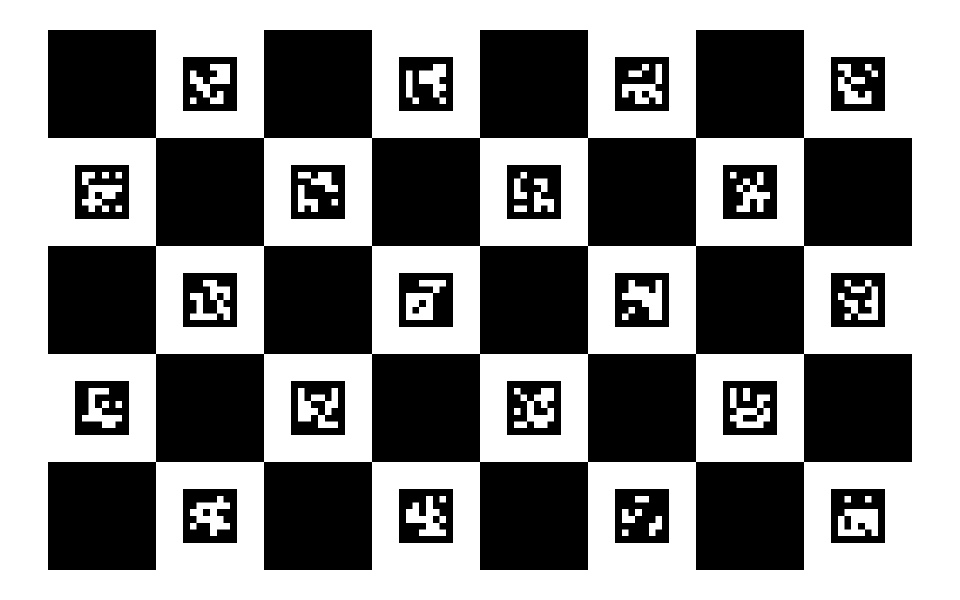

In [ ]:
# Calculate image height to preserve aspect ratio
charuco_img_height = int(image_width * num_squares_y / num_squares_x)

# Generate the ChArUco board image with given size and margin
charuco_image = cv2.aruco.CharucoBoard.generateImage(charuco_board,
    outSize=(image_width, charuco_img_height), marginSize=image_margin)

# Save the generated board image to the specified path
cv2.imwrite(charuco_image_path, charuco_image)

# Display preview for verification
cv2_imshow(cv2.resize(charuco_image, None, fx=0.25, fy=0.25))

# Step 2. Camera Calibration

This script uses a ChArUco board and a video sequence of the board to perform camera calibration. It:
1. Loads a video file.
2. Detects ChArUco patterns every N frames.
3. Extracts image and object points from valid frames.
4. Performs camera calibration.
5. Saves the resulting camera parameters to a .npz file.

'rmse' is the root mean square (RMS) reprojection error. It measures how well the estimated camera parameters match the observed image points. A smaller value indicates more accurate calibration.
* rmse < 0.5: Very good calibration.
* rmse ≈ 0.5 ~ 1.0: Sufficient for practical use.
* rmse > 1.0: May indicate noise; consider improving image quality or board detection.

`*` The above is only a guideline. RMS reprojection error is measured in pixels and can be affected by the size of the ChArUco board in the image. For example, if the board occupies most of the frame, even small detection errors can result in greater pixel deviation.

In [ ]:
# Open your videos
cap1 = cv2.VideoCapture(extrinsic_video_cam1_path)
cap2 = cv2.VideoCapture(extrinsic_video_cam2_path)

# Get image dimensions from the first frame of camera 1 (assuming both cameras have same resolution)
ret1, frame1 = cap1.read()
if not ret1:
    raise RuntimeError(f'Cannot read from {extrinsic_video_cam1_path}')

frame_height, frame_width = frame1.shape[:2]
frame_size = (frame_width, frame_height)
print(f'Frame size: {frame_size}')

# Discard the first frame of camera 2 to sync videos
cap2.read()

# Use the shorter video length for the progress bar if they're not matched
total_frames1 = int(cap1.get(cv2.CAP_PROP_FRAME_COUNT))
total_frames2 = int(cap2.get(cv2.CAP_PROP_FRAME_COUNT))
if total_frames1 != total_frames2:
    print('WARNING: The number of frames in the two videos does not match. They are supposed to be synchronized.')
num_frames = min(total_frames1, total_frames2)

# Setup ChArUco detector with refinement enabled
charuco_params = cv2.aruco.CharucoParameters()
charuco_params.tryRefineMarkers = True
charuco_detector = cv2.aruco.CharucoDetector(charuco_board, charuco_params)

# Termination criteria for corner subpixel refinement
termination_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Lists to store points from all valid paired frames
object_points_list = []    # 3D points in board space
image_points_list1 = []    # 2D points in camera 1
image_points_list2 = []    # 2D points in camera 2
visualization_frames = []  # Frames for optional GIF creation

# Progress tracking
processed_frames = 1
pbar = tqdm(total=num_frames, desc='Processing frames')
pbar.update(1)

# Main loop: read frames and detect ChArUco corners
while cap1.isOpened() and cap2.isOpened():
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()
    if not ret1 or not ret2:
        print('Finished processing videos or encountered an error reading frames')
        break

    processed_frames += 1
    pbar.update(1)

    # Skip frames based on the sampling interval
    if processed_frames % frame_sampling_interval != 0:
        continue

    # Convert to grayscale for detection
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # Detect ChArUco board in both frames
    # Returns: charuco_corners, charuco_ids, marker_corners, marker_ids
    corners1, ids1, _, _ = charuco_detector.detectBoard(gray1)
    corners2, ids2, _, _ = charuco_detector.detectBoard(gray2)

    # Skip if detection failed in either frame
    if ids1 is None or ids2 is None:
        continue

    # Find common marker IDs in both views
    common_ids = np.intersect1d(ids1.flatten(), ids2.flatten())
    if len(common_ids) < min_detected_corners:
        continue

    # Refine corner locations for subpixel accuracy
    corners1_refined = cv2.cornerSubPix(gray1, corners1, winSize=(11, 11),
        zeroZone=(-1, -1), criteria=termination_criteria)
    corners2_refined = cv2.cornerSubPix(gray2, corners2, winSize=(11, 11),
        zeroZone=(-1, -1), criteria=termination_criteria)

    # Retrieve object and image points for each camera
    obj_pts1, img_pts1 = cv2.aruco.getBoardObjectAndImagePoints(charuco_board,
        corners1_refined, ids1)
    _, img_pts2 = cv2.aruco.getBoardObjectAndImagePoints(charuco_board,
        corners2_refined, ids2)

    # Collect matching points across both cameras
    pts3d, pts2d_cam1, pts2d_cam2 = [], [], []
    for cid in common_ids:
        idx1 = np.where(ids1 == cid)[0][0]
        idx2 = np.where(ids2 == cid)[0][0]

        # Append the corresponding 3D object point from the board
        pts3d.append(obj_pts1[idx1])  # Use obj_points from cam1 (or cam2, as they are equal)

        # Append the detected 2D image points from both cameras
        pts2d_cam1.append(img_pts1[idx1])
        pts2d_cam2.append(img_pts2[idx2])

    object_points_list.append(np.array(pts3d, dtype=np.float32))
    image_points_list1.append(np.array(pts2d_cam1, dtype=np.float32))
    image_points_list2.append(np.array(pts2d_cam2, dtype=np.float32))

    # Prepare a combined view for GIF visualization
    cv2.aruco.drawDetectedCornersCharuco(frame1, corners1_refined, ids1)
    cv2.aruco.drawDetectedCornersCharuco(frame2, corners2_refined, ids2)
    combined = cv2.hconcat([frame1, frame2])
    combined = cv2.resize(combined, None, fx=0.5, fy=0.5)
    combined = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)
    visualization_frames.append(Image.fromarray(combined))

    # Stop early if we've gathered enough valid frame pairs
    if len(object_points_list) >= max_valid_frame_pairs:
        print(f'Reached maximum valid frames ({max_valid_frame_pairs}). Stopping.')
        break

# Release video resources and close progress bar
cap1.release()
cap2.release()
pbar.close()

print(f"Collected {len(object_points_list)} valid frame pairs.")

# Initialize intrinsic parameters
# Focal length is assumed to be the frame width
cam_matrix1 = np.array([[frame_width, 0, frame_width // 2],
                           [0, frame_width, frame_height// 2],
                           [0, 0, 1]], dtype=np.float32)
cam_matrix2 = np.array([[frame_width, 0, frame_width // 2],
                           [0, frame_width, frame_height// 2],
                           [0, 0, 1]], dtype=np.float32)
dist_coeffs1 = np.zeros(5)
dist_coeffs2 = np.zeros(5)

rmse, cam_matrix1, dist_coeffs1, cam_matrix2, dist_coeffs2,\
rotation, translation, _, _ = cv2.stereoCalibrate(
    object_points_list, image_points_list1, image_points_list2,
    cam_matrix1, dist_coeffs1, cam_matrix2, dist_coeffs2,
    frame_size, flags=cv2.CALIB_USE_INTRINSIC_GUESS
)

# Print calibration results
print("Calibration RMS error:", rmse)

# Save calibration results
np.savez(extrinsics_path, cam_matrix1=cam_matrix1, dist_coeffs1=dist_coeffs1,
    cam_matrix2=cam_matrix2, dist_coeffs2=dist_coeffs2,
    rotation=rotation, translation=translation)

Frame size: (1280, 720)


Processing frames:   0%|          | 0/1889 [00:00<?, ?it/s]

Finished processing videos or encountered an error reading frames
Collected 49 valid frame pairs.
Calibration RMS error: 0.3860979128363301


## Display Detection Result as GIF

In [ ]:
gif_path = 'tmp.gif'
visualization_frames[0].save(gif_path, save_all=True,
    append_images=visualization_frames[1:],
    duration=1000,  # milliseconds per frame
    loop=0)
IPython.display.Image(gif_path, format='png')

Output hidden; open in https://colab.research.google.com to view.

## Visualize the Spatial Relationship between Calibration Boards and Cameras

It plots:
* Multiple ChArUco boards' poses (XY plane).
* Fixed two cameras' poses (positions and orientations) as 3D frustums (pyramids).

Interactive 3D visualization allows you to move the viewing angle.

In [ ]:
# Create Plotly 3D lines for a camera frustum
def draw_camera_frustum(position, rotation_matrix):
    width = 0.2
    height = 0.6 * width
    depth = 0.8 * width

    # Four corners on the plane in camera coords
    cam_corners = [
        np.array([+width / 2, -height / 2, depth]),
        np.array([-width / 2, -height / 2, depth]),
        np.array([-width / 2, +height / 2, depth]),
        np.array([+width / 2, +height / 2, depth])
    ]
    cam_center = position.flatten()

    # Transform corners to world frame
    world_corners = [cam_center + rotation_matrix @ c for c in cam_corners]

    # Lines from center to each corner
    lines = []
    for i, corner in enumerate(world_corners):
        lines.append(go.Scatter3d(
            x=[cam_center[0], corner[0]],
            y=[cam_center[1], corner[1]],
            z=[cam_center[2], corner[2]],
            mode='lines',
            line=dict(width=3, color='blue'),
            name='Camera' if i == 0 else None,
            showlegend=True if i == 0 else False
        ))

    # Edges of the plane
    for i in range(4):
        start = world_corners[i]
        end = world_corners[(i + 1) % 4]
        lines.append(go.Scatter3d(
            x=[start[0], end[0]],
            y=[start[1], end[1]],
            z=[start[2], end[2]],
            mode='lines',
            line=dict(width=3, color='blue'),
            showlegend=False
        ))

    return lines

# Assemble figure
fig_data = []

# Camera 1 at origin
fig_data += draw_camera_frustum(
    position=np.zeros((3, 1)),
    rotation_matrix=np.eye(3)
)

# Camera 2 pose from calibration
fig_data += draw_camera_frustum(
    position=-rotation.T @ translation.reshape(3, 1),
    rotation_matrix=rotation.T
)

# Define board corners
board_width = num_squares_x * square_length
board_height = num_squares_y * square_length
board_corners = np.array([
    [0, 0, 0],
    [board_width, 0, 0],
    [board_width, board_height, 0],
    [0, board_height, 0]
])

# Calculate rotation and translation of boards
_, _, _, board_rvecs_cam1, board_tvecs_cam1 = cv2.calibrateCamera(
    objectPoints=object_points_list,
    imagePoints=image_points_list1,
    imageSize=frame_size,
    cameraMatrix=cam_matrix1,
    distCoeffs=dist_coeffs1
)

# Add each board pose as a semi-transparent Mesh3d
for idx, (rvec, tvec) in enumerate(zip(board_rvecs_cam1, board_tvecs_cam1)):
    rot_board, _ = cv2.Rodrigues(rvec)
    trans_board = tvec.reshape(3, 1)
    world_pts = [(rot_board @ corner.reshape(3, 1) + trans_board).flatten()
                 for corner in board_corners]
    pts_x = [p[0] for p in world_pts]
    pts_y = [p[1] for p in world_pts]
    pts_z = [p[2] for p in world_pts]
    fig_data.append(go.Mesh3d(x=pts_x, y=pts_y, z=pts_z,
        i=[0, 0], j=[1, 2], k=[2, 3],
        opacity=0.2, name='Board', showlegend=(idx == 0)))

# Plot figure
fig = go.Figure(data=fig_data)
fig.update_layout(
    scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', aspectmode='data'),
    title='Two cameras and moving board', showlegend=True
)
fig.show()